# Wind retrievals using onboard radiometers data

In this notebook we connect different building blocks that allow us to perform wind retrievals using Optimal Estimation.

We will use different libraries for this purpose:
- [xarray](https://docs.xarray.dev/en/stable/) for handling data (loading, processing, etc.)
- [Dask](https://docs.dask.org/en/stable/) for scheduling processing chunked data (partially under the hood of xarray)
- [Pandas](https://pandas.pydata.org/docs/) to interface with auxiliary files such as apriori data and covariance matrices; its use in this application will be limited.
- [pyOptimalEstimation](https://github.com/maahn/pyOptimalEstimation) provides the core functionality behind Optimal Estimation.
- [RTTOV/pyRTTOV](https://nwp-saf.eumetsat.int/site/software/rttov/documentation/) provides the radiative transfer functionality that pyOptimalEstimation uses to perform the retrieval. We use two functions mainly: runDirect (forward model) and runK (Jacobian calculation).

We us other auxiliar libraries (e.g. sys) that are useful for handling paths, etc. but are not part of the retrievals computations.

In [1]:
import sys
import os

import dask
import xarray as xr
import numpy as np
import pandas as pd

import pyOptimalEstimation as pyOE

import datetime 
from datetime import datetime 
import time

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


import pyproj
import pyresample
from pyresample import create_area_def, load_area, data_reduce, utils, AreaDefinition
from pyresample.geometry import SwathDefinition
from pyresample.kd_tree import resample_nearest

Next we append two paths where we have: auxiliary functions that we use (e.g. *support*) and the path where RTTOV's Python wrapper lives:

In [2]:
#sys.path.append('/nobackup/users/echeverr/Git/SatOpEst/support') # where supporting_routines_m live
sys.path.append('/home/mario/Documents/work/code/git/SatOpEst/support') # where supporting_routines_m live

import supporting_routines_m 

rttov_installdir = '/home/mario/myLibs/rrtov13/rttov130'

sys.path.append(rttov_installdir+'/wrapper')
import pyrttov


In this notebook we use [CMSAF](https://wui.cmsaf.eu/safira/action/viewDoiDetails?acronym=FCDR_MWI_V003) data (i.e. Temperature Brightness); these datasets contain several flags and they have been calibrated in order to provide backwards compatility from all instruments (SSMI and SSMIS) when refered to F11. 

For our experiments we decided to use SSMIS data as a template; in particular the SSMIS mounted on the F16 platform. We remind the user that this is a code in development stage and these were chosen parameters (SSMIS on F16) that were general enough.


In [3]:

#BT_dir = '/nobackup/users/echeverr/data/cmsaf/ssmis/F16/'
BT_dir = '/home/mario/Data/CMSAF/ssims/F16/'

BT_dir2 = BT_dir+'V1/'

BT_file = 'BTRin20140909000000324SSF1601GL'

BT_file2 = BT_file+'_v1'

In order to perform retrievals, the user defines a time period (init_date, end_date) within the day of observations that each CMSAF NetCDF file contains; this would be ideally a 'per orbit' type of time slot, but is not limited to that at this stage.

The user can also define the size of the chunks to be processed by each worker in the computing cluster; the data in CMSAF files has a spatial definition (i.e. Swath) defined in *across track* and *time* (this is effectively the *along track movement*). Each 2 seconds the satellite has moved *along track* and a new row *across track* is generated.

Initially for the channels that we are interested in (19 and 37 GHz) to start with, each *time* (also known as *along track*) contains 90 samples *across track*. So size 10 for chunks in *across track* will generate 9 chunks.

In [5]:
# user input:

init_date = np.datetime64('2014-09-09T00:00:00.000') 
end_date = np.datetime64('2014-09-09T00:59:59.000')

# Chunking the dataset (for 30 mins 10,10 works well (in my laptop, Mario); 
# if increase minutes times x, then increase chunk_size_time times x as well (avoids memory problems))
chunk_size_time =  10 # 420 for half day
chunk_size_s_a_t = 10

# Perform chisquare tests available in pyOptimalEstimation or not:
performTests = False


Now we define auxiliary functions; these are self-explanatory:

In [6]:
# returns the directory (str) corrisponding to the band where "lat" is located
def get_band(lat,dir_bands,lat_bands):
    i=0
    band_out=None
    for band in dir_bands: 
        if(np.logical_and(lat >= lat_bands[i][0], lat <= lat_bands[i][1])):
            band_out = band
        i+=1
    if(band_out==None):
        print("Error in lat:")
        print(lat)
        print(type(lat))
        sys.stderr.write("Error in lat")
        sys.exit(1)
        
    return band_out


def split_file_name(f):
    # Split a file name in parts, according to specific characters "_, 0, etc."
    aux1 = f.split(".")[0].split("0_")
    aux2 = aux1[1].split("_")
    season = aux1[0]
    aORb = aux2[0]
    meanORcov = aux2[1]
    return season, aORb, meanORcov

def get_mean_covs(directory,inputSeason):
# very badly programed look-up table: it will look
# for the files corrisponding to a given inputSeason 
# and return means and covariances for both state vector (a)
# and parameters vector (b).
    files = os.listdir(directory)
    for f in files:
        #print(f)
        season, aORb, meanORcov = split_file_name(f)
        if(inputSeason==season):
            if(aORb=='a'):
                if(meanORcov=='mean'):
                    xa = pd.read_csv(directory+f, 
                                     index_col=0).rename_axis('state', 
                                                              axis=0).rename_axis('stateT', 
                                                                                  axis=1)
                elif(meanORcov=='cov'):   
                    Sa = pd.read_csv(directory+f, 
                                     index_col=0).rename_axis('state', 
                                                              axis=0).rename_axis('stateT', 
                                                                                  axis=1)
                else:
                    print('Something went wrong, check:')
                    print(directory+f)
            elif(aORb=='b'):
                if(meanORcov=='mean'):
                    xb = pd.read_csv(directory+f, 
                                     index_col=0).rename_axis('state', 
                                                              axis=0).rename_axis('stateT', 
                                                                                  axis=1)
                elif(meanORcov=='cov'):   
                    Sb = pd.read_csv(directory+f, 
                                     index_col=0).rename_axis('state', 
                                                              axis=0).rename_axis('stateT', 
                                                                                  axis=1)
                else:
                    print('Something went wrong, check:')
                    print(directory+f)                
            
        
    return xa,Sa,xb,Sb   

get_mean_covs_vec = np.vectorize(get_mean_covs, otypes=[pd.core.frame.DataFrame,
                                                        pd.core.frame.DataFrame,
                                                        pd.core.frame.DataFrame,
                                                        pd.core.frame.DataFrame])

def reshape4profiles(profiles):
    # "profiles" is a numpy array
    # "profiles" can contain 1 or more profiles
    # "profiles" has dimensions (nlevels, nprofiles)
    # "outProfiles" has dimensions (nprofiles,nlevels) (as needed in RTTOV)
    
    if (len(profiles.shape)==1):
        outProfiles = profiles.reshape(1,profiles.shape[0]).copy()
    else:
        outProfiles = profiles.T.copy() #profiles.reshape(profiles.shape[1]
            #                          ,profiles.shape[0]) 
    return outProfiles  


def sleep_and_print_mem(title, sleep=3):
    time.sleep(sleep)
    print("\n" + title + " : " +  "%0.2f MB" % (p.memory_info().rss / 1e6)
         + "   " + "=" * 49)
    
def month2season(month):
    seasons = [
        'DJF',
        'MAM',
        'JJA',
        'SON',
    ]
    season = seasons[month-1] # month is 1 based index while seasons array needs 0 based indexing
   
    return season

month2season_vec = np.vectorize(month2season, otypes=[str])  

Function *forward_b_init*, initializes fixed parameters in RTTOV's profile instance *myProfiles*; such parameters are assumed ground-truth values. These parameters are simply all the other parameters that are not included in $x_a$ and $x_b$ (see ATBD document), but nevertheless are needed to run RTTOV. 

Further documentation about the functions in the next cells (*forward_b_init*, *forwardRT*, *rttovK*) can be found [here](https://github.com/deweatherman/RadEst/blob/main/crossVal_RTTOV_Kmodel_Jacobians.ipynb)

For specifics on RTTOV parameters, we refer the reader to RTTOV's documentation:

In [7]:
def forward_b_init(pressure, salinity, lat, long, datetime_obs64, 
                   zenithAngle, myProfiles):
    
    # Inputs: pressure, salinity, lat, long, 
    #          datetime_obs64, zenithAngle
    # Input/Output: myProfiles
    
    if (len(pressure.shape)==1):
        nprofiles = 1
    else:
        nprofiles =  pressure.shape[1]
    
    # The rest of the code uses datetime64 format (numpy), but I have to pass the obs date as integers to RTTOV
    datetime_obs = supporting_routines_m.datetime64_to_datetime(datetime_obs64)
    
    s2m = np.zeros((nprofiles,6), dtype=np.float64) # s2m has 6 elements (docs RTTOV)
    
    angles = np.zeros((nprofiles,4), dtype=np.float64) # angles has 4 elements (docs RTTOV)
    angles[:,0] = zenithAngle
    
    
    # for RTTOV 13 skin is 9 elements long:
    skin = np.zeros((nprofiles,9), dtype=np.float64) # skin has 9 elements (docs RTTOV)
    skin[:,1] = salinity
        
    surftype = np.zeros((nprofiles,2), dtype=np.int32) # surftype has 2 elements (docs RTTOV)
    surftype[:,:] = 1 # [sea, ocean] Harcoded for now, TODO *** mario
    
    
    surfgeom = np.zeros((nprofiles,3), dtype=np.float64) # surfgeom has 3 elements (docs RTTOV)
    surfgeom[:,0] = lat
    surfgeom[:,1] = long
    # surfgeom[:,2]=0 # elevation harcoded to 0 for now, TODO *** mario
    
    date_times = np.zeros((nprofiles,6), dtype=np.int32) # date_times has 6 elements (docs RTTOV)
    date_times[:,0] = datetime_obs.year
    date_times[:,1] = datetime_obs.month
    date_times[:,2] = datetime_obs.day
    date_times[:,3] = datetime_obs.hour
    date_times[:,4] = datetime_obs.minute
    date_times[:,5] = datetime_obs.second
    
    
    myProfiles.GasUnits = 1  # kg/kg (see RTTOV doc. for other options) # Harcoded for now, TODO *** mario
    myProfiles.P = reshape4profiles(pressure) 
    myProfiles.S2m = s2m
    myProfiles.Angles = angles
    myProfiles.Skin = skin
    myProfiles.SurfType = surftype
    myProfiles.SurfGeom = surfgeom
    myProfiles.DateTimes = date_times 

Functions *forwardRT* and *rttovK* are function handlers that we pass into the Optimal Estimation object (defined further down); these functions link the internal *state* and *parameters* vectors ($x_a$ and $x_b$ respectively) contained in variable $X$ with the external world (i.e. the forward model).

These are the functions that one would modify if one wants to use a different solver from RTTOV.

The input $X$ is a Pandas series, whose index is used to easily get specific variables from within; this presents at present a *speed* limitation (accessing variables via their index by name) and could be improved by making the indexing independent from variable names, but that would limit a bit the flexibility; the indexing (say a get method) is performed by function *splitX_all_2W*.

Notice that the humidity column values are in logarithmic scale (of g/kg) on the Optimal Estimation side (looking for better Gaussianity in their distribution), however RTTOV needs to receive a linear scale humidity, so we perform that conversion here.

The only difference between these two functions is (apart from one being the forward model and the other the Jacobian model) is that the Jacobian needs to fill a Pandas DataFrame  before returning to a simple Numpy array in output; this has to do with the internal workings of the Optimal Estimation library and its a point that could be improved (speed wise).

In [8]:
def forwardRT(X, myProfiles_a, ssmiRttov_a, channels_list=None):
    
    # TODO: Add assertions, tests *** mario
    
    # Wind W:
    temperature, humidity, w10m, t2m, tsk, sp \
    = supporting_routines_m.splitX_all_2W(X)    
    
    # humdity is in log10 scale, convert to linear in kg/kg
    humidity = (10**humidity) / 1000.
    # or abs_humidity? *** note mario

    myProfiles_a.T = reshape4profiles(temperature.to_numpy(dtype=np.float64))  
    myProfiles_a.Q = reshape4profiles(humidity.to_numpy(dtype=np.float64))  

    myProfiles_a.S2m[:,0] = reshape4profiles(
        sp.to_numpy(dtype=np.float64)).flatten() # surface pressure
    myProfiles_a.S2m[:,1] = reshape4profiles(
        t2m.to_numpy(dtype=np.float64)).flatten()  # 2m temperature
    myProfiles_a.Skin[:,0] = reshape4profiles(
        tsk.to_numpy(dtype=np.float64)).flatten() 
    
    # Wind W:
    myProfiles_a.S2m[:,3] = 0.7071*reshape4profiles(
        w10m.to_numpy(dtype=np.float64)).flatten()  #  10m windspeed
    myProfiles_a.S2m[:,4] = myProfiles_a.S2m[:,3]    
   
    ssmiRttov_a.Profiles = myProfiles_a

    try:
        ssmiRttov_a.runDirect(channels_list)
    except pyrttov.RttovError as e:
        sys.stderr.write("Error running RTTOV direct model: {!s}".format(e))
        sys.exit(1)    

    
    if(ssmiRttov_a.BtRefl[:, :].shape[0]==1):
        TB = ssmiRttov_a.BtRefl[0, :].T
    else:
        TB = ssmiRttov_a.BtRefl[:, :].T
    
    return TB

def rttovK(X, perturbation, y_var, myProfiles_a, ssmiRttov_a, channels_list=None):
    
    # TODO: Add assertions, tests *** mario

    # Wind W:
    temperature, humidity, w10m, t2m, tsk, sp \
    = supporting_routines_m.splitX_all_2W(X)        
    
    # humdity is in log10 scale, convert to linear in kg/kg
    humidity = (10**humidity) / 1000.

    myProfiles_a.T = reshape4profiles(temperature.to_numpy(dtype=np.float64))  
    myProfiles_a.Q = reshape4profiles(humidity.to_numpy(dtype=np.float64))  

    myProfiles_a.S2m[:,0] = reshape4profiles(
        sp.to_numpy(dtype=np.float64)).flatten() # surface pressure
    myProfiles_a.S2m[:,1] = reshape4profiles(
        t2m.to_numpy(dtype=np.float64)).flatten()  # 2m temperature
    myProfiles_a.Skin[:,0] = reshape4profiles(
        tsk.to_numpy(dtype=np.float64)).flatten()   
    
    # Wind W:
    myProfiles_a.S2m[:,3] = 0.7071*reshape4profiles(
        w10m.to_numpy(dtype=np.float64)).flatten()  #  10m windspeed
    myProfiles_a.S2m[:,4] = myProfiles_a.S2m[:,3] 
    
    ssmiRttov_a.Profiles = myProfiles_a
    
    try:
        ssmiRttov_a.runK(channels_list)
    except pyrttov.RttovError as e:
        sys.stderr.write("Error running RTTOV direct model: {!s}".format(e))
        sys.exit(1)
    
    # Create Jacobian Dataframe skeleton:
    jacx = pd.DataFrame(index=y_var, columns=X.index)  
    
    # Fill-in Jacobian Dataframe
    jacx = supporting_routines_m.mergeX_all_2W(jacx.T, X, 
                                            ssmiRttov_a,
                                            perturbation = perturbation, 
                                            LogHum=True)

    return jacx.T.to_numpy(dtype=np.float64) 

  

The function *rttovStructInit* creates an RTTOV instance for an instrument and initializes it. More over the specifics from the use and meaning of the different variables can be found on RTTOV's documentation or in [this](https://github.com/deweatherman/RadEst/blob/main/crossVal_RTTOV_Kmodel_Jacobians.ipynb) example.


In [9]:
def rttovStrucInit():
    # Set knobs for use of OpenMP in RTTOV

    NthreadsF = 1  # Number of threads for forward model  #os.cpu_count()
    NthreadsFM = 4 # Number of threads for forward model (in case of multiple profiles, used in) #os.cpu_count()
    NprofsPerCallFM = 40 # ?Roughly speaking number of variables (e.g. 279) / Number of threads (e.g. 8)
    # Create instance of Profiles class; 
    # it's a container of the input atmospheric state that RTTOV will simulate



    #  Create instance of RTTOV
    ssmiRttov = pyrttov.Rttov()

    #chan_list_ssmi = (12,13,14,15,16,17,18) #(1,12,13,14,15,16) #  #

    # Define instrument (FileCoef):
    ssmiRttov.FileCoef = '{}/{}'.format(rttov_installdir,
                                    "rtcoef_rttov13/rttov7pred54L/rtcoef_dmsp_16_ssmis.dat")

    # Load the instruments: for HIRS and MHS do not supply a channel list and
    # so read all channels
    try:
        ssmiRttov.loadInst() #chan_list_ssmi
    except pyrttov.RttovError as e:
        sys.stderr.write("Error loading instrument(s): {!s}".format(e))
        sys.exit(1)

    # Some settings
    ssmiRttov.Options.AddInterp = True
    # ssmiRttov.Options.InterpMode = 2
    ssmiRttov.Options.CO2Data = False
    ssmiRttov.Options.VerboseWrapper = False
    ssmiRttov.Options.DoCheckinput = False
    ssmiRttov.Options.UseQ2m = False
    ssmiRttov.Options.ApplyRegLimits = True
    ssmiRttov.Options.Verbose = False
    ssmiRttov.Options.FastemVersion = 6
    ssmiRttov.Options.Switchrad = True
    ssmiRttov.Options.Nthreads = NthreadsF

    # *********************************
    # *********************************
    return ssmiRttov

The *init_retrieval_data* does:
- Initializes a pyrttov profiles instance (needed to run RTTOV).
- Initializes a pyrttov instrument (needed to run RTTOV).
- Defines latitude bands and selects (according to the lat in input) which apriori data ($x_a$, $x_b$, $S_a$, $S_b$) to use. This is not ideal and is a point to improve (speed wise), because accessing these variables (stored in .csv) is very slow.
- Finds the right season according to the observation time and gets the right apriori data.
- Initializes the observations array and its variances.
- Finally it initializes the *OptimalEstimation* instance which we use to perform the retrieval.

This function is called for each observation point and could definitely be improved.

For the way to initialize the *OptimalEstimation* object, we refer the reader to the *pyOptimalEstimation* [documentation](https://pyoptimalestimation.readthedocs.io/en/latest/) or [this](https://github.com/deweatherman/RadEst/blob/main/crossVal_RTTOV_Kmodel_Jacobians.ipynb) annotated example.

In [10]:
# Add init function:

def init_retrieval_data(time_i, lat, lon, 
                        channels_list,
                        channel_uncertainty, BT,
                        zenithAngle, #dir_bands2,
                        #lat_bands2
                       ):  

    nprofiles = 1  # This is hardcoded (we use RTTOV within OE, workin on a single profile per OE)
    nlev = 37 # TODO: this needs to be read from the apriori data (covariances and means) 
    myProfiles = pyrttov.Profiles(nprofiles, nlev)
    ssmiRttov = rttovStrucInit()  

    aprioLowCapDir = '/home/mario/Data/Covariance_means/CDS_api_data/ERA5_data/lower_cap/'
    aprioLowMidCapDir = '/home/mario/Data/Covariance_means/CDS_api_data/ERA5_data/lowmid_cap/'
    aprioUpMidCapDir = '/home/mario/Data/Covariance_means/CDS_api_data/ERA5_data/upmid_cap/'
    aprioUpCapDir = '/home/mario/Data/Covariance_means/CDS_api_data/ERA5_data/upper_cap/'
    
    #aprioLowCapDir = '/nobackup/users/echeverr/data/ECMWF_era5/hourly_ERA5/mean_cov/lower_cap/'
    #aprioLowMidCapDir = '/nobackup/users/echeverr/data/ECMWF_era5/hourly_ERA5/mean_cov/lowmid_cap/'
    #aprioUpMidCapDir = '/nobackup/users/echeverr/data/ECMWF_era5/hourly_ERA5/mean_cov/upmid_cap/'
    #aprioUpCapDir = '/nobackup/users/echeverr/data/ECMWF_era5/hourly_ERA5/mean_cov/upper_cap/'   

    # list of directories contaning covariances and means; each dir contains one geographical zone 
    # Geo. zones are divided in latitude strips: [-90,-40), [-40,0), [0,+40), [+40,+90]; lon. [-180,+180) for all
    
    dir_bands = [aprioLowCapDir,aprioLowMidCapDir,aprioUpMidCapDir,aprioUpCapDir] # 
    lat_bands = [[-90.0,-40.0],[-40.0,0.0],[0.0,40.0],[40.0,90.0]]   # 
    
    months = (time_i.astype('datetime64[M]').astype(int) % 12 + 1)%12 // 3 + 1
    season = month2season_vec(months)
            
    y_obs = pd.Series(BT,
                index=channels_list
                     )            
            
    # TODO Sy needs to be loaded from somewhere according to the channels_list: ***********
            
    # Channels 12-16 (values from Deblonde-English 2003) (sigma or std)
    y_noise = pd.Series(channel_uncertainty,
                        index=channels_list)
                            
    # Variance values > std**2
    S_y = pd.DataFrame(
                np.diag(y_noise.values**2),
                index=channels_list,
                columns=channels_list,
    )
    # TODO Sy needs to be loaded from somewhere according to the channels_list  ***********
            
    datetime_obs = time_i #.values
    salinity = 35 # hardcoded, not good; TODO Mario
            
    band = get_band(lat,dir_bands,lat_bands) # gets the directory for the band where 'lat' is located
    xa,Sa,xb,Sb = get_mean_covs(band, season) # gets mean and covariances for the band and season
            
    # reverse order in x and S (profile variables are reordered from low pressure to high) 
    Sb = Sb.iloc[::-1,::-1]
    Sa = Sa.iloc[::-1,::-1]
    xb = xb.iloc[::-1].squeeze() # convert means from dataframe to series
    xa = xa.iloc[::-1].squeeze()
            
    x_vars = xa.index.values
    b_vars = xb.index.values
            
    # Get the pressure per level ; TODO: this needs to be independent of the variable (e.g. xb in this case)
    xb_index = [float(i.split('_')[0]) for i in xb.index if i.endswith('temp')]
    Pressure = np.array(xb_index).reshape(len(xb_index),1)
                        
    nlev = len([i for i in xb.index if i.endswith('temp')]) # number of levels in profile quantities


    # forward_b_init fills "myProfiles" with the "fixed" parameters for the RTTOV simulation.
    # The forward model F(x,b), RTTOV in our case, has two "parameters": x and b
    # x is the state vector that is being retrieved (as such it is allowed to change during the retrieval)
    # b contains all other parameters that are fixed during the retrieval (everything else that is not being retrieved)

    forward_b_init(Pressure, salinity,
                   lat, lon, datetime_obs, zenithAngle, myProfiles)
    
    # Define dictionary of parameters for the forward model:

    forwardKwArgs = {"myProfiles_a" : myProfiles, 
                    "ssmiRttov_a" : ssmiRttov,
                    "channels_list":channels_list.tolist()}          
        
    # Create OE object:
    
    oe_ref = pyOE.optimalEstimation( # oe_1 if windDisambiguation used
        x_vars, # state variable names
        xa,  # a priori
        Sa, # a priori uncertainty
        channels_list,  # measurement variable names
        y_obs, # observations
        S_y, # observation uncertainty
        forwardRT, # forward Operator
        userJacobian=rttovK, # RTTOV's K model operator
        forwardKwArgs=forwardKwArgs, # additonal function arguments
        #x_truth=x_truth, # true profile
        b_vars=b_vars,   # Parameter vector variable names
        b_p=xb,        # Parameter vector 
        S_b=Sb,        # Parameters error covariance matrix 
        perturbation=0.01,
        verbose=False
    )
    return oe_ref


CMSAF datasets are delivered per platform, per day; each dataset contains observations, flags and calibrations ready to be applied (but are effectively given separated as extra variables in the dataset). Each feed of the antenna in the platform has a slightly different "view" of the surface of the planet; this has been taken into account by separating the dataset into logical groups, where each group contains the channels that share the same feed. 

We would like to apply these flags and calibrations before using the data, this is done in another notebook (**preprocess**); in there we apply the calibrations and flags and then save into another NetCDF file with the same name and the addition *numberOfChannels* at the end.

The next cell:
- Opens the dataset with observations where CMSAF flas have been applied.
- Creates the variables (dataarrays) in the same dataset in order to exploit the already existing dimensions *time* and *scene_across_track*.
- If the user decides to perform the statistical tests included in *pyOptimalEstimation* then the variables containing those results are created as well.

In [11]:
# Load TB dataset:

times = xr.open_dataset(BT_dir2+BT_file2+'5chan'+'.nc').time
print(type(times))
# nearest to user input in dataset:
init_date = times.sel(time=init_date, method = "nearest")
end_date = times.sel(time=end_date, method = "nearest")

times = None

DS_CMSAF_ocean = xr.open_dataset(BT_dir2+BT_file2+'5chan'+'.nc'
                                    ).sel(time=slice(init_date,end_date),
                                          #scene_channel=np.array([11,12,14,15]),
                                         ).chunk({"time": chunk_size_time,
                                             "scene_across_track": chunk_size_s_a_t})


DS_CMSAF_ocean['wind'] = xr.DataArray(
                data   = np.full((DS_CMSAF_ocean.time.shape[0],
                                  DS_CMSAF_ocean.scene_across_track.shape[0]),
                                 np.nan, dtype = np.float32),   # enter data here
                dims   = ['time','scene_across_track'],
                coords = {'time': DS_CMSAF_ocean.time, 
                          'scene_across_track':DS_CMSAF_ocean.scene_across_track},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': 'Near surface wind speed (NSWP)',
                    'units'     : 'm/s'
                    }
                ).chunk({"time": chunk_size_time,
                         "scene_across_track": chunk_size_s_a_t})

DS_CMSAF_ocean['wind_err'] = xr.DataArray(
                data   = np.full((DS_CMSAF_ocean.time.shape[0],
                                  DS_CMSAF_ocean.scene_across_track.shape[0]),
                                 np.nan, dtype = np.float32),   # enter data here
                dims   = ['time','scene_across_track'],
                coords = {'time': DS_CMSAF_ocean.time, 
                          'scene_across_track':DS_CMSAF_ocean.scene_across_track},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': 'NSWP uncertainty',
                    'units'     : 'm/s'
                    }
                ).chunk({"time": chunk_size_time,
                         "scene_across_track": chunk_size_s_a_t})

if(performTests):
    sizeResults = 6 # parameter on apply_ufunc
    workerMemLimit = '4GB' # For cluster definition (works well for 1 hour of CMSAF data)
    DS_CMSAF_ocean['chiSquareTest1'] = xr.DataArray(
                data   = np.full((DS_CMSAF_ocean.time.shape[0],
                                  DS_CMSAF_ocean.scene_across_track.shape[0]),
                                 np.nan, dtype = np.float32),   # enter data here
                dims   = ['time','scene_across_track'],
                coords = {'time': DS_CMSAF_ocean.time, 
                          'scene_across_track':DS_CMSAF_ocean.scene_across_track},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': 'Optimal solution agrees with observation in Y space',
                    'units'     : 'True/False'
                    }
                ).chunk({"time": chunk_size_time,
                         "scene_across_track": chunk_size_s_a_t})
    DS_CMSAF_ocean['chiSquareTest2'] = xr.DataArray(
                data   = np.full((DS_CMSAF_ocean.time.shape[0],
                                  DS_CMSAF_ocean.scene_across_track.shape[0]),
                                 np.nan, dtype = np.float32),   # enter data here
                dims   = ['time','scene_across_track'],
                coords = {'time': DS_CMSAF_ocean.time, 
                          'scene_across_track':DS_CMSAF_ocean.scene_across_track},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': 'Observation agrees with prior in Y space',
                    'units'     : 'True/False'
                    }
                ).chunk({"time": chunk_size_time,
                         "scene_across_track": chunk_size_s_a_t})
    DS_CMSAF_ocean['chiSquareTest3'] = xr.DataArray(
                data   = np.full((DS_CMSAF_ocean.time.shape[0],
                                  DS_CMSAF_ocean.scene_across_track.shape[0]),
                                 np.nan, dtype = np.float32),   # enter data here
                dims   = ['time','scene_across_track'],
                coords = {'time': DS_CMSAF_ocean.time, 
                          'scene_across_track':DS_CMSAF_ocean.scene_across_track},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': 'Optimal solution agrees with prior in Y space',
                    'units'     : 'True/False'
                    }
                ).chunk({"time": chunk_size_time,
                         "scene_across_track": chunk_size_s_a_t})
    DS_CMSAF_ocean['chiSquareTest4'] = xr.DataArray(
                data   = np.full((DS_CMSAF_ocean.time.shape[0],
                                  DS_CMSAF_ocean.scene_across_track.shape[0]),
                                 np.nan, dtype = np.float32),   # enter data here
                dims   = ['time','scene_across_track'],
                coords = {'time': DS_CMSAF_ocean.time, 
                          'scene_across_track':DS_CMSAF_ocean.scene_across_track},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': 'Optimal solution agrees with priot in X space',
                    'units'     : 'True/False'
                    }
                ).chunk({"time": chunk_size_time,
                         "scene_across_track": chunk_size_s_a_t})
    
else:
    sizeResults = 2 # parameter on apply_ufunc
    workerMemLimit = '2GB' # For cluster definition (works well for 1 hour of CMSAF data)
    
DS_CMSAF_ocean

<class 'xarray.core.dataarray.DataArray'>


<xarray.Dataset>
Dimensions:              (time: 1897, scene_across_track: 90, scene_channel: 5)
Coordinates:
  * scene_across_track   (scene_across_track) int32 1 5 9 13 ... 345 349 353 357
  * scene_channel        (scene_channel) int64 11 12 13 14 15
  * time                 (time) datetime64[ns] 2014-09-09 ... 2014-09-09T01:0...
Data variables:
    lat                  (time, scene_across_track) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    lon                  (time, scene_across_track) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    eia                  (time, scene_across_track) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
    sft                  (time, scene_across_track) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
    tb                   (time, scene_across_track, scene_channel) float32 dask.array<chunksize=(10, 10, 5), meta=np.ndarray>
    global_channel_ID    (scene_channel) int32 dask.array<chunksize=(5,), meta=np.ndarray>
    channel_uncertainty  (scene_channel) float32 dask.array<chunksize=(5,), meta=np.ndarray>
    wind                 (time, scene_across_track) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
    wind_err             (time, scene_across_track) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
Attributes:
    title:                 Environmental Scene 1
    comment:               feedhorn channels: h19, v19, v22
    elevation_offset_deg:  0.4
    azimuth_offset_deg:    -0.3

Function *retrieveWind* receives a batch of observations with some useful metadata:
- Temperature Brightness (tb)
- Time of the observation (time)
- List of channels to be used in the retrieval (global_channel)
- Uncertainties of all the channels (channel_uncertainty)
- Latitude and Longitude of the observation (lat, lon)
- Angle of incidence of the observation (eia)
- Perform or not the statistical tests for each observation (performTests)

In case the apriori is eventually computed using ECMWF's forecasts (i.e. 1 apriori per observation), this function will include those apriori data (say as the lat or lon) and then into the *init_retrieval_data* to end up in $x_a$ (and $x_b$ if desired).


In [12]:

def retrieveWind(time, tb, global_channel,
                 channel_uncertainty,
                 lat, lon, eia,  
                 performTests,
                ):
    
    wind = np.full(lat.shape, np.nan, dtype=np.float32)
    wind_err = np.full(lat.shape, np.nan, dtype=np.float32)
    if(performTests):
        chiSquareTest1 = np.full(lat.shape,np.nan,dtype=np.float32)
        chiSquareTest2 = np.full(lat.shape,np.nan,dtype=np.float32)
        chiSquareTest3 = np.full(lat.shape,np.nan,dtype=np.float32)
        chiSquareTest4 = np.full(lat.shape,np.nan,dtype=np.float32)

    if((~np.isnan(lat))and(~np.any(np.isnan(tb)))):  # Input dataset has been filtered for sea-land flag (so both, lat and lon are valid or nan)
        
        oe_ref = init_retrieval_data(time,
                                     lat, lon,
                                     global_channel,
                                     channel_uncertainty,
                                     tb,
                                     eia,
                                    )

        oe_ref.doRetrieval()     
    
        if oe_ref.converged:  # 
            _, _, w10m, _, _,_ = supporting_routines_m.splitX_all_2W(oe_ref.x_op)
            _, _, w10m_err, _, _,_ = supporting_routines_m.splitX_all_2W(oe_ref.x_op_err)
    
            wind =  w10m.values.item()
            wind_err =  w10m_err.values.item()
            
            if(performTests):      
                chiSquareTest1 = np.float32(oe_ref.chiSquareTest()[0][0])
                chiSquareTest2 = np.float32(oe_ref.chiSquareTest()[0][1])
                chiSquareTest3 = np.float32(oe_ref.chiSquareTest()[0][2])
                chiSquareTest4 = np.float32(oe_ref.chiSquareTest()[0][3])
    
    if(performTests):
        out = np.array([wind, wind_err,
                    chiSquareTest1,
                    chiSquareTest2,
                    chiSquareTest3,
                    chiSquareTest4,])
    else:
        out = np.array([wind, wind_err,])
        
    return out  

            

At this stage we are ready to create the computation cluster to process the data; here we take the dataset *DS_CMSAF_ocean* that contains observations and useful metadata (eventually also the apriori data), which contains 1 day of observations (from CMSAF) and we divide it in time batches of the desired length (here we use half an our). Then we loop around each batch. 

For each batch or group we: 
- Create a [LocalCluster](https://distributed.dask.org/en/stable/api.html#distributed.LocalCluster) that will received the chunked dataset (chunked in our case in variables *time* and *scene_across_track*). 
- We create a universal function [*apply_ufunc*](https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html) from xarray. *apply_ufunc* handles each chunk of data to one worker and it manages the communication for the parallel computation automatically.
 * The method *compute()* simply tells xarray (and Dask under the hood) to actually perform the computation; if *compute()* is not called, the computation graph is built, but not executed.
 * We also chunk the dataset in output; this was a test (mainly), one should avoid chunking a dataset excesively as this adds taks to the computation graph (reducing performance).
- The output dataarray *out_wind* is concatenated (for all of the time batches or groups).
- Once all the time batches/groups are processed, we save the resulting dataarray as part of the original observations, this is optional; it is done here for convenience (dimensions of swath data are the same).
- Finally we save the dataset to a NetCDF file (we add the word *Winds* to differentiate it from the original observations file).

In [13]:
# Analysis (retrievals)

#os.environ["MALLOC_TRIM_THRESHOLD_"] = "0" #"65536" #
from dask.distributed import Client, progress, LocalCluster

startTimeAll = time.time()

# Group per hour or couple of hours in order to avoid having memory issues in workers:

DS_CMSAF_ocean_grouped = DS_CMSAF_ocean.resample(time='0.5H') 
i=0

for hour_name, hour_group in DS_CMSAF_ocean_grouped:
    
    startTimeHour = time.time()

    with LocalCluster(threads_per_worker = 1, 
                      n_workers = 8, memory_limit = workerMemLimit,
                      processes=True
                     ) as cluster, Client(cluster) as client:
        
        out_wind = xr.apply_ufunc(retrieveWind,
                                  hour_group.time,
                                  hour_group.tb,
                                  hour_group.global_channel_ID,
                                  hour_group.channel_uncertainty,
                                  hour_group.lat, hour_group.lon,
                                  hour_group.eia,
                                  performTests,
                                  input_core_dims=[[], 
                                               ["scene_channel"], 
                                               ["scene_channel"],
                                               ["scene_channel"],[],[],[],[],#[],[],
                                              ],
                                  exclude_dims= set(("scene_channel",)),
                                  output_core_dims=[
                                      ["results"],
                                  ],
                                  dask="parallelized",
                                  output_dtypes=[hour_group.wind.dtype],
                                  dask_gufunc_kwargs={
                                      'output_sizes':{
                                          "results": sizeResults}},
                                  vectorize=True
                                 ).compute().chunk({"time": chunk_size_time,
                                                    "scene_across_track": chunk_size_s_a_t})
           
    print("%.2f s , Time_Hour" % (time.time()-startTimeHour)) 

    if(i==0):
        out_wind_1 = out_wind    
    else:
        out_wind_1 = xr.concat((out_wind_1, out_wind), dim = "time")

    print("Time group:")
    print(i)
    print("Done!")
    i+=1
    
DS_CMSAF_ocean["wind"].data = out_wind_1.data[:,:,0]
DS_CMSAF_ocean["wind_err"].data = out_wind_1.data[:,:,1]
if(performTests):
    DS_CMSAF_ocean["chiSquareTest1"].data = out_wind_1.data[:,:,2]
    DS_CMSAF_ocean["chiSquareTest2"].data = out_wind_1.data[:,:,3]
    DS_CMSAF_ocean["chiSquareTest3"].data = out_wind_1.data[:,:,4]
    DS_CMSAF_ocean["chiSquareTest4"].data = out_wind_1.data[:,:,5]
    

print("%.2f s , TimeAll_hour" % (time.time()-startTimeAll))

# Write ds including retrieved winds and wind uncertainty:

from dask.diagnostics import ProgressBar

with LocalCluster(threads_per_worker = 1, 
                  n_workers = 8, memory_limit = workerMemLimit,
                  processes=True
                 ) as cluster, Client(cluster) as client:
    delayed_obj = DS_CMSAF_ocean.to_netcdf(BT_dir2+BT_file2+"Winds"+'.nc', compute=False)
    with ProgressBar():
        results = delayed_obj.compute()

2022-11-01 12:17:40,758 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
2022-11-01 12:17:40,760 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2022-11-01 12:17:40,771 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2022-11-01 12:17:40,773 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
2022-11-01 12:17:40,779 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2022-11-01 12:17:40,780 - distributed.nanny - WARNING - Worker process still alive after 3.199998474121094 seconds, killing
2022-11-01 12:17:40,782 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2022-11-01 12:17:40,783 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing


1251.04 s , Time_Hour
Time group:
0
Done!


Task was destroyed but it is pending!
task: <Task pending name='Task-97995' coro=<RequestHandler._execute() running at /home/mario/anaconda3/envs/pyOpEst/lib/python3.9/site-packages/tornado/web.py:1704> wait_for=<Future pending cb=[<TaskWakeupMethWrapper object at 0x7f43689bb760>()]> cb=[_HandlerDelegate.execute.<locals>.<lambda>() at /home/mario/anaconda3/envs/pyOpEst/lib/python3.9/site-packages/tornado/web.py:2326]>
2022-11-01 12:44:23,369 - distributed.nanny - WARNING - Worker process still alive after 3.1999987792968754 seconds, killing
2022-11-01 12:44:23,370 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
2022-11-01 12:44:23,379 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2022-11-01 12:44:23,381 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
2022-11-01 12:44:23,382 - distributed.nanny - WARNING - Worker process still a

1602.59 s , Time_Hour
Time group:
1
Done!
7.94 s , Time_Hour
Time group:
2
Done!
2861.74 s , TimeAll_hour


In [ ]:
# If loading dataset for plotting:

testDir = BT_dir2
testDS = BT_file2+"Winds"
DS_CMSAF_ocean = xr.open_dataset(testDir+testDS+'.nc'
                                    ).chunk({"time": chunk_size_time,
                                             "scene_across_track": chunk_size_s_a_t})
DS_CMSAF_ocean     

In [14]:
def mapPlotScat(x,y,data,namefile, mini, maxi, orthoCenter=None):
    # Make a Mercator map of the data using Cartopy
      
    fig = plt.figure()
    

    #ortho = ccrs.Orthographic(0,-15) # ccrs.Orthographic(60,-15)
    ortho = ccrs.PlateCarree()
    ax = plt.axes(projection=ortho)
        
    #crs = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
    geo = ccrs.PlateCarree() #ccrs.Geodetic()
    #crs = ccrs.Orthographic(60,-15)
        
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black',linewidth=0.1)
    
    xy = ortho.transform_points(geo, x, y)

    ax.set_global()
    ax.gridlines()    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.07, 
                      color='black', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER  
    

    # Plot the air temperature as colored circles and the wind speed as vectors.
    im = ax.scatter(
        xy[:,0],
        xy[:,1],
        c=data,
        s=0.2, #0.15
        edgecolors= 'none',
        marker = matplotlib.markers.MarkerStyle(marker='o',fillstyle='full'),#"o",
        cmap="viridis",
        #transform=crs,
        vmin=mini, vmax=maxi,  # 3,18
        #vmin=130, vmax=270,  # 180, 270        
    )
    fig.colorbar(im).set_label("10m Wind Speed, RadEst [m/s]")
    #fig.colorbar(im).set_label("Temp. Bright [K]")
    
# Use an utility function to add tick labels and land and ocean features to the map.

    plt.tight_layout()
    #plt.show()
    plt.savefig(namefile+'.png', bbox_inches='tight', dpi=450)  

In [15]:
def mapPlotScatZoom(x,y,data,namefile, mini, maxi, orthoCenter=None, area=None):
    # Make a Mercator map of the data using Cartopy
      
    fig = plt.figure()
    
    if(area==None):
        #ortho = ccrs.Orthographic(0,-15) # ccrs.Orthographic(60,-15)
        ortho = ccrs.PlateCarree()
        ax = plt.axes(projection=ortho)
        
        #crs = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
        geo = ccrs.PlateCarree() #ccrs.Geodetic()
        #crs = ccrs.Orthographic(60,-15)
    else:
        crs = area.to_cartopy_crs()
        #ortho = crs.Orthographic(0,-15) # crs.Orthographic(60,-15)
        ortho = crs #crs.PlateCarree()
        ax = plt.axes(projection=ortho)
        
        #crs = crs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
        geo = ccrs.PlateCarree() #ccrs.Geodetic()
        #crs = crs.Orthographic(60,-15)
        
    
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black',linewidth=0.1)
    
    xy = ortho.transform_points(geo, x, y)

    ax.set_global()
    ax.gridlines()    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.07, 
                      color='black', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER  
    

    # Plot the air temperature as colored circles and the wind speed as vectors.
    im = ax.scatter(
        xy[:,0],
        xy[:,1],
        c=data,
        s=0.4, #0.15
        edgecolors= 'none',
        marker = matplotlib.markers.MarkerStyle(marker='o',fillstyle='full'),#"o",
        cmap="viridis",
        #transform=crs,
        vmin=mini, vmax=maxi,  # 3,18
        #vmin=130, vmax=270,  # 180, 270        
    )
    fig.colorbar(im).set_label("10m Wind Speed, RadEst [m/s]")
    #fig.colorbar(im).set_label("Temp. Bright [K]")
    
# Use an utility function to add tick labels and land and ocean features to the map.

    plt.tight_layout()
    #plt.show()
    plt.savefig(namefile+'.jpg', bbox_inches='tight', dpi=900)  
    
    
def defineArea(corners, proj_id, datum):
    #corners=parseMeta(data_name)

    lat_0 = '{lat_0:5.2f}'.format_map(corners)
    lon_0= '{lon_0:5.2f}'.format_map(corners)
    lon_bbox = [corners['min_lon'],corners['max_lon']]
    lat_bbox = [corners['min_lat'],corners['max_lat']]
    area_dict = dict(datum=datum,lat_0=lat_0,lon_0=lon_0,
                proj=proj_id,units='m')

    #area_dict = dict(datum=datum,lat_0=-15,lon_0=60,
    #            proj=proj_id,units='m',a=6370997.0,)

    prj=pyproj.Proj(area_dict)
    x, y = prj(lon_bbox, lat_bbox)
    xsize=200
    ysize=200
    area_id = 'granule'
    area_name = 'modis swath 5min granule'
    area_extent = (x[0], y[0], x[1], y[1])
    print(area_extent)
    area_def = AreaDefinition(area_id, area_name, proj_id, 
                                   area_dict, xsize, ysize,area_extent)
    return area_def    

In [16]:
# World map:

area_def_world = load_area('areas.yaml', 'worldeqc30km70')# 'worldeqc30km70') # for plots
grid_lons_world, grid_lats_world = area_def_world.get_lonlats()

swath_radEst = SwathDefinition(lons=DS_CMSAF_ocean.lon.values, lats=DS_CMSAF_ocean.lat.values)
lons_radEst, lats_radEst = swath_radEst.get_lonlats()

In [17]:
world_lons, world_lats, world_wind_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_world, grid_lats_world,
                            lons_radEst, lats_radEst, DS_CMSAF_ocean.wind.values,
                            radius_of_influence=1000)
world_lons, world_lats, world_wind_err_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_world, grid_lats_world,
                            lons_radEst, lats_radEst, DS_CMSAF_ocean.wind_err.values,
                            radius_of_influence=1000)


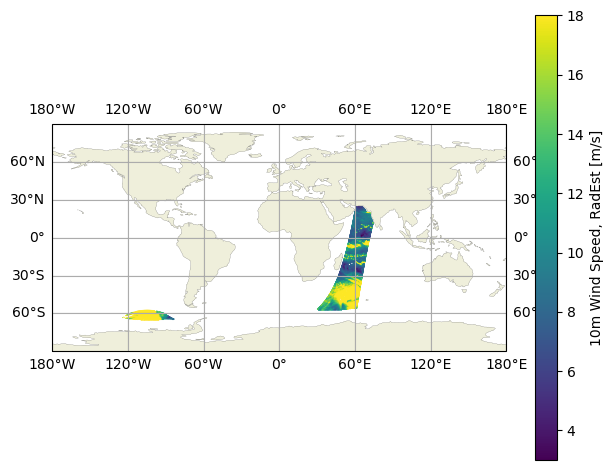

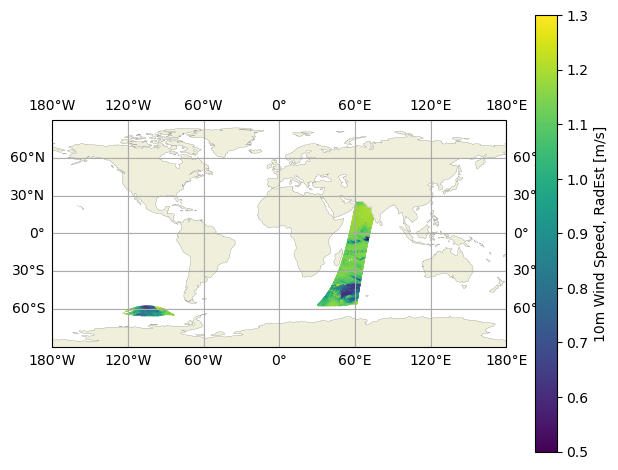

In [18]:
mapPlotScat(world_lons, world_lats, world_wind_radEst,
                 'World_wind_RadEst_Plat', 3,18)
mapPlotScat(world_lons, world_lats, world_wind_err_radEst,
                 'World_wind_Err_RadEst_Plat',0.5,1.3)

In [23]:
# Creation of area of interest:
corners = {"min_lon": 25 , "max_lon": 75, "min_lat": -30 , "max_lat": 0, "lat_0": 60, "lon_0":-15}
proj_id = 'eqc'  # eqc
datum = 'WGS84'
area_interest = defineArea(corners, proj_id, datum)
grid_lons_zoom, grid_lats_zoom = area_interest.get_lonlats()

(4452779.631730943, -10018754.171394622, 10018754.171394622, -6679169.447596414)


In [24]:
zoom_lons, zoom_lats, zoom_wind_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_zoom, grid_lats_zoom,
                            lons_radEst, lats_radEst, DS_CMSAF_ocean.wind.values,
                            radius_of_influence=1000)
zoom_lons, zoom_lats, zoom_wind_err_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_zoom, grid_lats_zoom,
                            lons_radEst, lats_radEst, DS_CMSAF_ocean.wind_err.values,
                            radius_of_influence=1000)


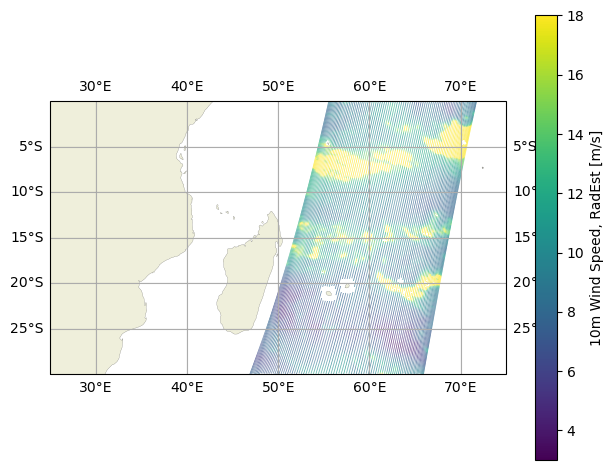

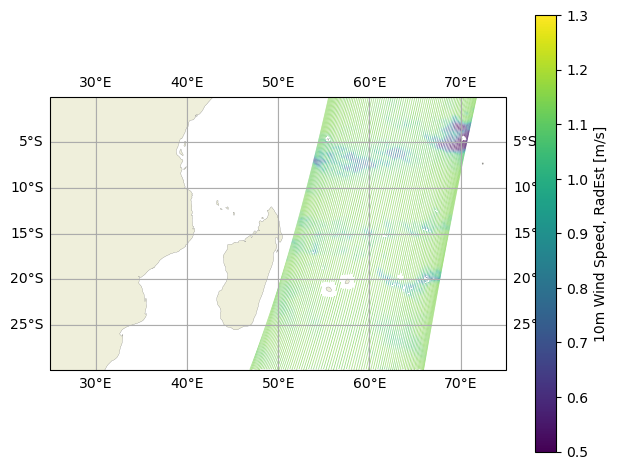

In [25]:
mapPlotScatZoom(zoom_lons, zoom_lats, zoom_wind_radEst,
                 'zoom_wind_RadEst_Plat', 3,18,area=area_interest)
mapPlotScatZoom(zoom_lons, zoom_lats, zoom_wind_err_radEst,
                 'zoom_wind_err_radEst', 0.5,1.3,area=area_interest)
